In [10]:
import numpy as np
import pandas as pd
import pywt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. 데이터 로드
# data = pd.read_csv('../project/trainStockDataTemp/SK하이닉스allTemp.csv') # 테스트
data = pd.read_csv('./data/000660.csv',encoding='cp949')
data = data[int(len(data['종가'])/2):]
data = data[['종가','거래량']]
data.rename(columns={'종가':'Close','거래량':'Volume'},inplace=True)
prices = data['Close'].values  # 종가 데이터
volumes = data['Volume'].values  # 거래량 데이터


# 2. CWT 특징 추출
def extract_cwt_features(data, wavelet='morl', scales=np.arange(1, 128)):
    coeffs, _ = pywt.cwt(data, scales, wavelet)
    return coeffs

# 종가와 거래량의 CWT 특징 추출
cwt_price_features = extract_cwt_features(prices)
cwt_volume_features = extract_cwt_features(volumes)


# 3. 데이터 전처리
def create_dataset(features, target, time_step=1):
    X, y = [], []
    for i in range(len(features) - time_step):
        if i + time_step < len(target):  # 타겟 길이 확인
            X.append(features[i:(i + time_step), :])
            y.append(target[i + time_step])
    return np.array(X), np.array(y)

# CWT 특징을 2D로 변환 (행: 시간, 열: 특징)


cwt_price_features = np.array(cwt_price_features) #학습
cwt_volume_features = np.array(cwt_volume_features)#학습

# cwt_price_features = np.array(backTesting_price) #테스트
# cwt_volume_features = np.array(backTesting_volume)#테스트

# 특징과 타겟 변수를 생성
X_price, y_price = create_dataset(cwt_price_features.T, prices[1:], time_step=10)
X_volume, y_volume = create_dataset(cwt_volume_features.T, volumes[1:], time_step=10)

# X를 합치기
X = np.concatenate((X_price, X_volume), axis=2)


In [13]:

# 데이터셋 분할
# X_train, X_test, y_train, y_test = train_test_split(X, y_price, test_size=0.2, random_state=42)
X_train = X[:int(len(X) * 0.8), :, :]
X_test = X[int(len(X) * 0.8):, :, :]
y_train = y_price[:int(len(y_price) * 0.8)]
y_test = y_price[int(len(y_price) * 0.8):]


Epoch [10/100], Loss: 0.0876
Epoch [20/100], Loss: 0.0775
Epoch [30/100], Loss: 0.0763
Epoch [40/100], Loss: 0.0743
Epoch [50/100], Loss: 0.0734
Epoch [60/100], Loss: 0.0731
Epoch [70/100], Loss: 0.0727
Epoch [80/100], Loss: 0.0722
Epoch [90/100], Loss: 0.0720
Epoch [100/100], Loss: 0.0717


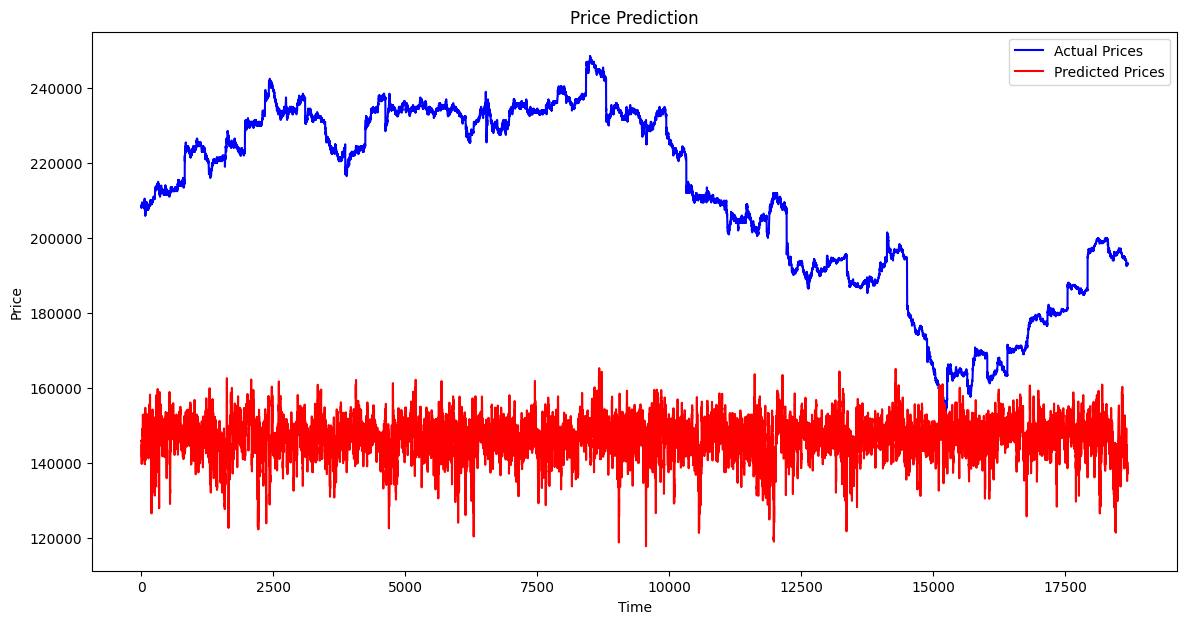

In [14]:


# 데이터 정규화
scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()

# 4. LSTM 모델 구축
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 마지막 시퀀스의 출력만 사용
        return out

# 하이퍼파라미터 설정
input_size = X.shape[2]
hidden_size = 50
num_layers = 2
model = LSTMModel(input_size, hidden_size, num_layers)

# 5. 모델 훈련
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(torch.Tensor(X_train))
    loss = criterion(outputs.squeeze(), torch.Tensor(y_train))
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


# 6. 예측
model.eval()
with torch.no_grad():
    predicted = model(torch.Tensor(X_test)).numpy()
    predicted = scaler.inverse_transform(predicted)  # 원래 스케일로 되돌리기
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# 7. 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='Actual Prices', color='blue')
plt.plot(predicted, label='Predicted Prices', color='red')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()




In [15]:
# 8. 백테스팅
initial_capital = 200000 # 초기 자본
capital = initial_capital
position = 0  # 현재 보유 주식 수

for i in range(len(predicted) - 1):
    if predicted[i] < predicted[i + 1]:  # 가격 상승 예측
        if position == 0:  # 현재 주식이 없는 경우
            position = (capital // y_test_original[i].item())  # 매수 가능한 주식 수
            capital -= position * y_test_original[i].item()  # 자본에서 주식 구입 비용 차감
    elif predicted[i] > predicted[i + 1]:  # 가격 하락 예측
        if position > 0:  # 현재 주식이 있는 경우
            capital += position * y_test_original[i].item()  # 주식 매도
            position = 0  # 주식 보유 수량 초기화

# 최종 자본 계산
final_capital = capital + (position * y_test_original[-1].item() if position > 0 else 0)  # 최종 자본
print(f'초기 자본: {initial_capital}, 최종 자본: {final_capital:.2f}, 수익률: {(final_capital - initial_capital) / initial_capital * 100:.2f}%')

초기 자본: 200000, 최종 자본: 200600.00, 수익률: 0.30%


In [16]:
import pandas as pd

# 데이터프레임 초기화
data = {
    'Actual Price': y_test_original.flatten(),  # 실제 가격
    'Predicted Price': predicted.flatten(),  # 예측 가격
    'Signal': [0] * len(predicted)  # 초기 신호는 0으로 설정
}

# 매수 및 매도 신호 추가
initial_capital = 1000000  # 초기 자본
capital = initial_capital
position = 0  # 현재 보유 주식 수

for i in range(len(predicted) - 1):
    if predicted[i] < predicted[i + 1]:  # 가격 상승 예측
        if position == 0:  # 현재 주식이 없는 경우
            data['Signal'][i] = 1  # 매수 신호
            position = (capital // y_test_original[i].item())  # 매수 가능한 주식 수
            capital -= position * y_test_original[i].item()  # 자본에서 주식 구입 비용 차감
    elif predicted[i] > predicted[i + 1]:  # 가격 하락 예측
        if position > 0:  # 현재 주식이 있는 경우
            data['Signal'][i] = 0  # 매도 신호
            capital += position * y_test_original[i].item()  # 주식 매도
            position = 0  # 주식 보유 수량 초기화

# 데이터프레임 생성
results_df = pd.DataFrame(data)

# 마지막 시점에 대한 신호 업데이트
if position > 0:
    results_df['Signal'].iloc[-1] = 0  # 마지막 시점에 매도 신호

# 결과 출력
print(results_df)


       Actual Price  Predicted Price  Signal
0          208500.0    145854.421875       0
1          208000.0    145798.171875       1
2          208000.0    145968.937500       0
3          208000.0    144364.296875       0
4          209000.0    143465.281250       0
...             ...              ...     ...
18677      193200.0    137068.546875       1
18678      193000.0    138843.390625       0
18679      192800.0    138435.890625       0
18680      193000.0    137447.000000       1
18681      193200.0    137499.812500       0

[18682 rows x 3 columns]


C:\Users\G013\AppData\Local\Temp\ipykernel_5060\1685398594.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  results_df['Signal'].iloc[-1] = 0  # 마지막 시점에 매도 신호
C:\Users\G013\AppData\Local\Temp\ipykernel_5060\1685398594.py:32: SettingWithC